# Model Playground

**Various tests and small experiments on toy networks.**

In [22]:
from imp import reload
import nupic.research.frameworks.dynamic_sparse.networks.layers as layers
reload(layers);
import nupic.research.frameworks.dynamic_sparse.networks.layers as networks
reload(networks);

In [59]:
from collections import OrderedDict

import numpy as np
import torch
from torchvision import models
from nupic.research.frameworks.dynamic_sparse.networks.layers import DSConv2d
from nupic.torch.models.sparse_cnn import gsc_sparse_cnn, gsc_super_sparse_cnn, GSCSparseCNN, MNISTSparseCNN
from nupic.research.frameworks.dynamic_sparse.networks import mnist_sparse_dsnn, GSCSparseFullCNN, gsc_sparse_dsnn_fullyconv
from torchsummary import summary

from torchviz import make_dot

# Load Models

In [61]:
# resnet18 = models.resnet18()
resnet50 = models.resnet50()

alexnet = models.alexnet()
# mnist_scnn = MNISTSparseCNN()
gsc_scnn = GSCSparseCNN()
# dscnn = mnist_sparse_dscnn({})
# gscf = gsc_sparse_dscnn_fullyconv({'prune_methods': ["none", "static"]}) # GSCSparseFullCNN(cnn_out_channels=(32, 64, 1))

In [541]:
# resnet18
# resnet18
# mnist_scnn
gsc_scnn
# dscnn
# gscf

GSCSparseCNN(
  (cnn1): Conv2d(1, 64, kernel_size=(5, 5), stride=(1, 1))
  (cnn1_batchnorm): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
  (cnn1_maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (cnn1_kwinner): KWinners2d(channels=64, n=0, percent_on=0.095, boost_strength=1.5, boost_strength_factor=0.9, k_inference_factor=1.5, duty_cycle_period=1000)
  (cnn2): Conv2d(64, 64, kernel_size=(5, 5), stride=(1, 1))
  (cnn2_batchnorm): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
  (cnn2_maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (cnn2_kwinner): KWinners2d(channels=64, n=0, percent_on=0.125, boost_strength=1.5, boost_strength_factor=0.9, k_inference_factor=1.5, duty_cycle_period=1000)
  (flatten): Flatten()
  (linear): SparseWeights(
    weight_sparsity=0.4
    (module): Linear(in_features=1600, out_features=1000, bias=True)
  )
  (linear_bn

In [412]:
inp = torch.rand(2, 1, 32, 32)
gsc_scnn(inp).shape
gscf(inp).shape

summary(gscf, input_size=(1, 32, 32))

hi <class 'nupic.torch.models.sparse_cnn.GSCSparseCNN'>
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 28, 28]             832
       BatchNorm2d-2           [-1, 32, 28, 28]               0
        KWinners2d-3           [-1, 32, 28, 28]               0
         MaxPool2d-4           [-1, 32, 14, 14]               0
      SparseConv2d-5           [-1, 64, 10, 10]          51,264
       BatchNorm2d-6           [-1, 64, 10, 10]               0
        KWinners2d-7           [-1, 64, 10, 10]               0
         MaxPool2d-8             [-1, 64, 5, 5]               0
           Flatten-9                 [-1, 1600]               0
           Linear-10                   [-1, 12]          19,212
       LogSoftmax-11                   [-1, 12]               0
Total params: 71,308
Trainable params: 71,308
Non-trainable params: 0
-----------------------------------------

# Fun with sequentials.

In [336]:
sq0 = torch.nn.Sequential(OrderedDict([('sq1', torch.nn.Sequential(OrderedDict([('cnn1', torch.nn.Conv2d(3, 3, 3))])) )]))
sq1 = torch.nn.Sequential(od)
sq2 = torch.nn.Sequential(torch.nn.Sequential(od), torch.nn.Conv2d(3, 3, 3))
sq3 = torch.nn.Sequential(OrderedDict([('sq1', sq1), ('sq2', sq2)]))
sq4 = torch.nn.Sequential(sq3)

In [339]:
for n, m in sq4.named_modules():
    ns = n.split('.')
    print([n_.isdigit() for n_ in ns])
    print('name')
    print(n, m)   

# for n, m in sq2._modules.items():
#     print(n, m)   

[False]
name
 Sequential(
  (0): Sequential(
    (sq1): Sequential(
      (cnn1): Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1))
    )
    (sq2): Sequential(
      (0): Sequential(
        (cnn1): Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1))
      )
      (1): Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1))
    )
  )
)
[True]
name
0 Sequential(
  (sq1): Sequential(
    (cnn1): Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1))
  )
  (sq2): Sequential(
    (0): Sequential(
      (cnn1): Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1))
    )
    (1): Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1))
  )
)
[True, False]
name
0.sq1 Sequential(
  (cnn1): Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1))
)
[True, False, False]
name
0.sq1.cnn1 Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1))
[True, False]
name
0.sq2 Sequential(
  (0): Sequential(
    (cnn1): Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1))
  )
  (1): Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1))
)
[True, False, True]
name
0.sq2.0

## Fun with grads

In [114]:
v1 = torch.tensor([0., 0., 0.], requires_grad=True)
v2 = torch.tensor([1., 2., 3.], requires_grad=True)
v3 = torch.tensor([5.], requires_grad=True)
v4 = (v1.sum() + v2.sum()) / v3
h = v3.register_hook(lambda grad: grad * 1.5)  # double the gradient

v4.backward(torch.tensor([1.]))
v1.grad, v2.grad, v3.grad

(tensor([0.2000, 0.2000, 0.2000]),
 tensor([0.2000, 0.2000, 0.2000]),
 tensor([-0.3600]))

In [118]:
v1 = torch.tensor([1., 4., 1.], requires_grad=True)
v2 = torch.tensor([1., 2., 3.], requires_grad=True)
v3 = torch.tensor([5.], requires_grad=True)
v4 = (v1.sum() + v2.sum()) / v3
h = v3.register_hook(lambda grad: grad * 3.0)  # double the gradient

v4.backward(torch.tensor([1.]))
v1.grad, v2.grad, v3.grad

(tensor([0.2000, 0.2000, 0.2000]),
 tensor([0.2000, 0.2000, 0.2000]),
 tensor([-1.4400]))

# Wide RESNET

In [262]:
import math
import torch
import torch.nn as nn
import torch.nn.functional as F


class BasicBlock(nn.Module):
    def __init__(self, in_planes, out_planes, stride, dropRate=0.0):
        super(BasicBlock, self).__init__()
        self.bn1 = nn.BatchNorm2d(in_planes)
        self.relu1 = nn.ReLU(inplace=True)
        self.conv1 = nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                               padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_planes)
        self.relu2 = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_planes, out_planes, kernel_size=3, stride=1,
                               padding=1, bias=False)
        self.droprate = dropRate
        self.equalInOut = (in_planes == out_planes)
        self.convShortcut = (not self.equalInOut) and nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride,
                               padding=0, bias=False) or None
    def forward(self, x):
        if not self.equalInOut:
            x = self.relu1(self.bn1(x))
        else:
            out = self.relu1(self.bn1(x))
        out = self.relu2(self.bn2(self.conv1(out if self.equalInOut else x)))
        if self.droprate > 0:
            out = F.dropout(out, p=self.droprate, training=self.training)
        out = self.conv2(out)
        return torch.add(x if self.equalInOut else self.convShortcut(x), out)

class NetworkBlock(nn.Module):
    def __init__(self, nb_layers, in_planes, out_planes, block, stride, dropRate=0.0):
        super(NetworkBlock, self).__init__()
        self.layer = self._make_layer(block, in_planes, out_planes, nb_layers, stride, dropRate)
    def _make_layer(self, block, in_planes, out_planes, nb_layers, stride, dropRate):
        layers = []
        for i in range(int(nb_layers)):
            layers.append(block(i == 0 and in_planes or out_planes, out_planes, i == 0 and stride or 1, dropRate))
        return nn.Sequential(*layers)
    def forward(self, x):
        return self.layer(x)

class WideResNet(nn.Module):
    def __init__(self, depth, num_classes, widen_factor=1, dropRate=0.0):
        super(WideResNet, self).__init__()
        nChannels = [16, 16*widen_factor, 32*widen_factor, 64*widen_factor]
        assert((depth - 4) % 6 == 0)
        n = (depth - 4) / 6
        block = BasicBlock
        # 1st conv before any network block
        self.conv1 = nn.Conv2d(3, nChannels[0], kernel_size=3, stride=1,
                               padding=1, bias=False)
        # 1st block
        self.block1 = NetworkBlock(n, nChannels[0], nChannels[1], block, 1, dropRate)
        # 2nd block
        self.block2 = NetworkBlock(n, nChannels[1], nChannels[2], block, 2, dropRate)
        # 3rd block
        self.block3 = NetworkBlock(n, nChannels[2], nChannels[3], block, 2, dropRate)
        # global average pooling and classifier
        self.bn1 = nn.BatchNorm2d(nChannels[3])
        self.relu = nn.ReLU(inplace=True)
        self.fc = nn.Linear(nChannels[3], num_classes)
        self.nChannels = nChannels[3]

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()
            elif isinstance(m, nn.Linear):
                m.bias.data.zero_()
    def forward(self, x):
        out = self.conv1(x)
        out = self.block1(out)
        out = self.block2(out)
        out = self.block3(out)
        out = self.relu(self.bn1(out))
        out = F.avg_pool2d(out, 8)
        out = out.view(-1, self.nChannels)
        return self.fc(out)

In [267]:
WideResNet(16, 10)

WideResNet(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (block1): NetworkBlock(
    (layer): Sequential(
      (0): BasicBlock(
        (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace)
        (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace)
        (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (1): BasicBlock(
        (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace)
        (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace)
      

# Fun with Learning Rates and Decays

In [586]:
import torch
import numpy as np

np.random.seed(123)
np.set_printoptions(8, suppress=True)

x_numpy = np.random.random((3, 4)).astype(np.double)
x_torch = torch.tensor(x_numpy, requires_grad=True)
x_torch2 = torch.tensor(x_numpy, requires_grad=True)

w_numpy = np.random.random((4, 5)).astype(np.double)
w_torch = torch.tensor(w_numpy, requires_grad=True)
w_torch2 = torch.tensor(w_numpy, requires_grad=True)

def log_grad(grad):
    print(grad)
    
w_torch.register_hook(log_grad)
w_torch2.register_hook(log_grad)

lr = 0.00001
weight_decay = 0.9
sgd = torch.optim.SGD([w_torch], lr=lr, weight_decay=0)
sgd2 = torch.optim.SGD([w_torch2], lr=lr, weight_decay=weight_decay)

y_torch = torch.matmul(x_torch, w_torch)
y_torch2 = torch.matmul(x_torch2, w_torch2)

loss = y_torch.sum()
loss2 = y_torch2.sum()

sgd.zero_grad()
sgd2.zero_grad()

loss.backward()
loss2.backward()

sgd.step()
sgd2.step()

w_grad = w_torch.grad.data.numpy()
w_grad2 = w_torch2.grad.data.numpy()

print("check_grad")
print(w_grad)
print(w_grad2 - weight_decay * w_numpy)


tensor([[1.8969, 1.8969, 1.8969, 1.8969, 1.8969],
        [1.1014, 1.1014, 1.1014, 1.1014, 1.1014],
        [1.5508, 1.5508, 1.5508, 1.5508, 1.5508],
        [1.9652, 1.9652, 1.9652, 1.9652, 1.9652]], dtype=torch.float64)
tensor([[1.8969, 1.8969, 1.8969, 1.8969, 1.8969],
        [1.1014, 1.1014, 1.1014, 1.1014, 1.1014],
        [1.5508, 1.5508, 1.5508, 1.5508, 1.5508],
        [1.9652, 1.9652, 1.9652, 1.9652, 1.9652]], dtype=torch.float64)
check_grad
[[1.89687006 1.89687006 1.89687006 1.89687006 1.89687006]
 [1.10136331 1.10136331 1.10136331 1.10136331 1.10136331]
 [1.55079367 1.55079367 1.55079367 1.55079367 1.55079367]
 [1.96519422 1.96519422 1.96519422 1.96519422 1.96519422]]
[[1.89687006 1.89687006 1.89687006 1.89687006 1.89687006]
 [1.10136331 1.10136331 1.10136331 1.10136331 1.10136331]
 [1.55079367 1.55079367 1.55079367 1.55079367 1.55079367]
 [1.96519422 1.96519422 1.96519422 1.96519422 1.96519422]]


# More fun with Gradients

In [1]:
import torch

# -----------------
# Helper function
# -----------------
def shape(t):
    if isinstance(t, tuple):
        return tuple(t_.shape if t_ is not None else None for t_ in t)
    else:
        return t.shape

# -----------------
# Grad hooks
# -----------------

# Zeros grad for weights
def w_hook(grad):
    print(' '*8, 'w-grad shape = ', shape(grad))
    grad[:] = 0
    return grad

# No change for biases.
def b_hook(grad):
    print(' '*8, 'b-grad shape = ', shape(grad))
    return grad

# -----------------------
# Test layers with biases
# -----------------------

# The following should confirm whether non-zero biases with non-zero gradient flows
# yield changes to the the weights of the layer - indepent of those weights' grad flows.  

layer1 = torch.nn.Conv2d(3, 3, 3)
layer2 = torch.nn.Linear(10, 100)
in1 = torch.rand(10, 3, 10, 10)
in2 = torch.rand(10, 10, 10)

for layer, input_ in [(layer1, in1), (layer2, in2)]:
    
    print('-------', layer.__class__.__name__, '--------\n')
    layer.weight.register_hook(w_hook)
    layer.bias.register_hook(b_hook)

    optim = torch.optim.SGD(layer.parameters(), lr=0.01)
    
    # Sets all weights and biases to 1.
    with torch.no_grad():
        layer.weight.data[:] = 1
        layer.bias.data[:] = 1

    optim.zero_grad()
    o = layer(input_)
    loss = o.mean()
    
    print(' '*5, 'Computing grads...')
    loss.backward()
    optim.step()
    
    # See if weights and biases are still 1.
    # This should only be the case for the weights
    # as we zeroed their gradients.
    print()
    print(' '*5, 'Checking results...')
    print(' '*8, 'Optimized weight - All close to 1:', (layer.weight == 1).all())
    print(' '*8, 'Optimized Bias - All close to 1:', (layer.bias == 1).all())
    print()


------- Conv2d --------

      Computing grads...
         w-grad shape =  torch.Size([3, 3, 3, 3])
         b-grad shape =  torch.Size([3])

      Checking results...
         Optimized weight - All close to 1: tensor(True)
         Optimized Bias - All close to 1: tensor(False)

------- Linear --------

      Computing grads...
         b-grad shape =  torch.Size([100])
         w-grad shape =  torch.Size([100, 10])

      Checking results...
         Optimized weight - All close to 1: tensor(True)
         Optimized Bias - All close to 1: tensor(False)



# Fun with Datasets and Dataloaders.

In [40]:
from torchvision import datasets, transforms

In [41]:
import os

In [78]:
data_dir = "~/nta/datasets"
data_dir = os.path.expanduser(data_dir)
if os.path.exists(data_dir):
    dataset = getattr(datasets, "CIFAR10")(
                    root=data_dir, train=True, transform=[transforms.ToTensor()]
                )
else:
    print("Couldn't find path {}".format(data_dir))

In [79]:
tl = torch.utils.data.DataLoader(
    dataset, batch_size=4, shuffle=True
)

In [80]:
class C(torch.nn.Conv2d):
    def to(self, device, *args, **kwargs):
        print(device, args)
        super().to(device, *args, **kwargs)

# Fun with iterators

In [51]:
class L(list):
    def __iter__(self):
        elem = super().__iter__()
        print('elem', elem)
        return elem

In [52]:
l = L([1, 2, 3])

In [54]:
for l_ in l:
    print(l_)

elem <list_iterator object at 0x11d864438>
1
2
3


# Small Dense GSC nets

In [101]:
np.set_printoptions(suppress=True)
params = np.array([1600, 102400, 1600000, 12000])

In [188]:
def _get_gsc_small_dense_params(on_perc, verbose=False):
    
    def vprint(*args):
        if verbose:
            print(*args)
    
    # Define number of params in dense GSC.
    # TODO: make configurable based off orignal `cnn_out_channels` and `linear_units`
    # default_config = dict(
    #     cnn_out_channels=(64, 64),
    #     linear_units=1000,
    # )
    large_dense_params = np.array([1600, 102400, 1600000, 12000])
    
    # Cacluate num params in large sparse GSC.
    large_sparse_params = large_dense_params * on_perc
    
    # Caclculate number of params in small dense.
    kernel_adjustment_factor = np.array([25, 25, 1, 1])
    small_sparse_params = large_sparse_params / kernel_adjustment_factor
    
    # Init desired congfig.
    cnn_out_channels = np.array([0, 0])
    linear_units = None

    # Assume 1 channel input to first conv
    cnn_out_channels[0] = large_sparse_params[0] / 25
    cnn_out_channels[1] = large_sparse_params[1] / (cnn_out_channels[0] * 25)
    cnn_out_channels = np.round(cnn_out_channels).astype(np.int)
    linear_units = large_sparse_params[2] / (25 * cnn_out_channels[1])
    linear_units = int(np.round(linear_units))

    # Simulate foward pass for sanity check
    conv1 = torch.nn.Conv2d(1, cnn_out_channels[0], 5)
    maxp1 = torch.nn.MaxPool2d(2)
    conv2 = torch.nn.Conv2d(cnn_out_channels[0], cnn_out_channels[1], 5)
    maxp2 = torch.nn.MaxPool2d(2)
    flat = torch.nn.Flatten()
    lin1 = torch.nn.Linear(25 * cnn_out_channels[1], linear_units)
    lin2 = torch.nn.Linear(linear_units, 12)
    
    x = torch.rand(10, 1, 32, 32)
    x = conv1(x)
    x = maxp1(x)
    x = conv2(x)
    x = maxp2(x)
    x = flat(x)
    x = lin1(x)
    x = lin2(x)
    
    # Calculate number of params.
    new_params = {
        "conv_1": np.prod(conv1.weight.shape),
        "conv_2": np.prod(conv2.weight.shape),
        "lin1": np.prod(lin1.weight.shape),
        "lin2": np.prod(lin2.weight.shape),
    }

    # Compare with desired.
    total_new = 0
    total_old = 0
    for p_old, (layer, p_new) in zip(large_sparse_params, new_params.items()):
        abs_diff = p_new - p_old
        rel_diff = abs_diff / float(p_old)
        vprint('---- {} -----'.format(layer))
        vprint('   new - ', p_new)
        vprint('   old - ', p_old)
        vprint('   abs diff:', abs_diff)
        vprint('   rel diff: {}% change'.format(100 * rel_diff))
        vprint()
        total_new += p_new
        total_old += p_old
    
    total_abs_diff = total_new - total_old
    total_rel_diff = total_abs_diff / float(total_old)
    vprint('---- Summary ----')
    vprint('   total new - ', total_new)
    vprint('   total old - ', total_old)
    vprint('   total abs diff:', total_abs_diff)
    vprint('   total rel diff: {}% change'.format(100 * total_rel_diff))
    
    # New config
    new_config = dict(
        cnn_out_channels=tuple(cnn_out_channels),
        linear_units=linear_units,
    )
    return new_config

for perc in [0.02, 0.04, 0.06, 0.08, 0.10]:
    c = _get_gsc_small_dense_params(perc, verbose=True)
    net = GSCSparseCNN(**c)

---- conv_1 -----
   new -  25
   old -  32.0
   abs diff: -7.0
   rel diff: -21.875% change

---- conv_2 -----
   new -  2025
   old -  2048.0
   abs diff: -23.0
   rel diff: -1.123046875% change

---- lin1 -----
   new -  32400
   old -  32000.0
   abs diff: 400.0
   rel diff: 1.25% change

---- lin2 -----
   new -  192
   old -  240.0
   abs diff: -48.0
   rel diff: -20.0% change

---- Summary ----
   total new -  34642
   total old -  34320.0
   total abs diff: 322.0
   total rel diff: 0.9382284382284383% change
---- conv_1 -----
   new -  50
   old -  64.0
   abs diff: -14.0
   rel diff: -21.875% change

---- conv_2 -----
   new -  4050
   old -  4096.0
   abs diff: -46.0
   rel diff: -1.123046875% change

---- lin1 -----
   new -  64800
   old -  64000.0
   abs diff: 800.0
   rel diff: 1.25% change

---- lin2 -----
   new -  384
   old -  480.0
   abs diff: -96.0
   rel diff: -20.0% change

---- Summary ----
   total new -  69284
   total old -  68640.0
   total abs diff: 644.0
 

In [184]:
net

GSCSparseCNN(
  (cnn1): Conv2d(1, 1, kernel_size=(5, 5), stride=(1, 1))
  (cnn1_batchnorm): BatchNorm2d(1, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
  (cnn1_maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (cnn1_kwinner): KWinners2d(channels=1, n=0, percent_on=0.095, boost_strength=1.6699999570846558, boost_strength_factor=0.9, k_inference_factor=1.5, duty_cycle_period=1000)
  (cnn2): Conv2d(1, 81, kernel_size=(5, 5), stride=(1, 1))
  (cnn2_batchnorm): BatchNorm2d(81, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
  (cnn2_maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (cnn2_kwinner): KWinners2d(channels=81, n=0, percent_on=0.125, boost_strength=1.6699999570846558, boost_strength_factor=0.9, k_inference_factor=1.5, duty_cycle_period=1000)
  (flatten): Flatten()
  (linear): SparseWeights(
    weight_sparsity=0.4
    (module): Linear(in_features=2025, out_features=16, bia

In [117]:
    
for perc in [0.02, 0.04, 0.06, 0.08, 0.10]:
    old_params = params * perc
    display(old_params) 
    factor = np.array([25, 25, 1, 1])
    new_params = old_params / factor
    new_params = np.round(new_params).astype(np.int) * factor
    display(new_params)
    
    diff = new_params - (old_params)
    print(diff)
    print(np.sum(diff))
    print(np.sum(diff) / np.sum(old_params))

    
    print()

array([   32.,  2048., 32000.,   240.])

array([   25,  2050, 32000,   240])

[-7.  2.  0.  0.]
-5.0
-0.0001456876456876457



array([   64.,  4096., 64000.,   480.])

array([   75,  4100, 64000,   480])

[11.  4.  0.  0.]
15.0
0.00021853146853146853



array([   96.,  6144., 96000.,   720.])

array([  100,  6150, 96000,   720])

[4. 6. 0. 0.]
10.0
9.712509712509713e-05



array([   128.,   8192., 128000.,    960.])

array([   125,   8200, 128000,    960])

[-3.  8.  0.  0.]
5.0
3.642191142191142e-05



array([   160.,  10240., 160000.,   1200.])

array([   150,  10250, 160000,   1200])

[-10.  10.   0.   0.]
0.0
0.0



# Fun with Resnets

In [62]:
resnet50

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [65]:
# Skip to content
# Search or jump to…

# Pull requests
# Issues
# Marketplace
# Explore
 
# @mvacaporale 
# Learn Git and GitHub without any code!
# Using the Hello World guide, you’ll start a branch, write comments, and open a pull request.


# Code Issues 40 Pull requests 14 Projects 0 Wiki Security Pulse Community
# DeepLearningExamples/PyTorch/Classification/RN50v1.5/image_classification/resnet.py
# @nvpstr nvpstr Updating PyTorch models
# 5eaebef on May 27
# 272 lines (221 sloc)  8.15 KB
  
import math
import torch
import torch.nn as nn
import numpy as np

__all__ = ['ResNet', 'build_resnet', 'resnet_versions', 'resnet_configs']

# ResNetBuilder {{{

class ResNetBuilder(object):
    def __init__(self, version, config):
        self.config = config

        self.L = sum(version['layers'])
        self.M = version['block'].M

    def conv(self, kernel_size, in_planes, out_planes, stride=1):
        if kernel_size == 3:
            conv = self.config['conv'](
                    in_planes, out_planes, kernel_size=3, stride=stride,
                    padding=1, bias=False)
        elif kernel_size == 1:
            conv = nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride,
                             bias=False)
        elif kernel_size == 5:
            conv = nn.Conv2d(in_planes, out_planes, kernel_size=5, stride=stride,
                             padding=2, bias=False)
        elif kernel_size == 7:
            conv = nn.Conv2d(in_planes, out_planes, kernel_size=7, stride=stride,
                             padding=3, bias=False)
        else:
            return None

        if self.config['nonlinearity'] == 'relu':
            nn.init.kaiming_normal_(conv.weight,
                    mode=self.config['conv_init'],
                    nonlinearity=self.config['nonlinearity'])

        return conv

    def conv3x3(self, in_planes, out_planes, stride=1):
        """3x3 convolution with padding"""
        c = self.conv(3, in_planes, out_planes, stride=stride)
        return c

    def conv1x1(self, in_planes, out_planes, stride=1):
        """1x1 convolution with padding"""
        c = self.conv(1, in_planes, out_planes, stride=stride)
        return c

    def conv7x7(self, in_planes, out_planes, stride=1):
        """7x7 convolution with padding"""
        c = self.conv(7, in_planes, out_planes, stride=stride)
        return c

    def conv5x5(self, in_planes, out_planes, stride=1):
        """5x5 convolution with padding"""
        c = self.conv(5, in_planes, out_planes, stride=stride)
        return c

    def batchnorm(self, planes, last_bn=False):
        bn = nn.BatchNorm2d(planes)
        gamma_init_val = 0 if last_bn and self.config['last_bn_0_init'] else 1
        nn.init.constant_(bn.weight, gamma_init_val)
        nn.init.constant_(bn.bias, 0)

        return bn

    def activation(self):
        return self.config['activation']()

# ResNetBuilder }}}

# BasicBlock {{{
class BasicBlock(nn.Module):
    M = 2
    expansion = 1

    def __init__(self, builder, inplanes, planes, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        self.conv1 = builder.conv3x3(inplanes, planes, stride)
        self.bn1 = builder.batchnorm(planes)
        self.relu = builder.activation()
        self.conv2 = builder.conv3x3(planes, planes)
        self.bn2 = builder.batchnorm(planes, last_bn=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        if self.bn1 is not None:
            out = self.bn1(out)

        out = self.relu(out)

        out = self.conv2(out)

        if self.bn2 is not None:
            out = self.bn2(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out
# BasicBlock }}}

# Bottleneck {{{
class Bottleneck(nn.Module):
    M = 3
    expansion = 4

    def __init__(self, builder, inplanes, planes, stride=1, downsample=None):
        super(Bottleneck, self).__init__()
        self.conv1 = builder.conv1x1(inplanes, planes)
        self.bn1 = builder.batchnorm(planes)
        self.conv2 = builder.conv3x3(planes, planes, stride=stride)
        self.bn2 = builder.batchnorm(planes)
        self.conv3 = builder.conv1x1(planes, planes * self.expansion)
        self.bn3 = builder.batchnorm(planes * self.expansion, last_bn=True)
        self.relu = builder.activation()
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual

        out = self.relu(out)

        return out
# Bottleneck }}}

# ResNet {{{
class ResNet(nn.Module):
    def __init__(self, builder, block, layers, num_classes=1000):
        self.inplanes = 64
        super(ResNet, self).__init__()
        self.conv1 = builder.conv7x7(3, 64, stride=2)
        self.bn1 = builder.batchnorm(64)
        self.relu = builder.activation()
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(builder, block, 64, layers[0])
        self.layer2 = self._make_layer(builder, block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(builder, block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(builder, block, 512, layers[3], stride=2)
        self.avgpool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Linear(512 * block.expansion, num_classes)

    def _make_layer(self, builder, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            dconv = builder.conv1x1(self.inplanes, planes * block.expansion,
                                    stride=stride)
            dbn = builder.batchnorm(planes * block.expansion)
            if dbn is not None:
                downsample = nn.Sequential(dconv, dbn)
            else:
                downsample = dconv

        layers = []
        layers.append(block(builder, self.inplanes, planes, stride, downsample))
        self.inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(builder, self.inplanes, planes))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        if self.bn1 is not None:
            x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)

        return x
# ResNet }}}


resnet_configs = {
        'classic' : {
            'conv' : nn.Conv2d,
            'conv_init' : 'fan_out',
            'nonlinearity' : 'relu',
            'last_bn_0_init' : False,
            'activation' : lambda: nn.ReLU(inplace=True),
            },
        'fanin' : {
            'conv' : nn.Conv2d,
            'conv_init' : 'fan_in',
            'nonlinearity' : 'relu',
            'last_bn_0_init' : False,
            'activation' : lambda: nn.ReLU(inplace=True),
            },
        }

resnet_versions = {
        'resnet18' : {
            'net' : ResNet,
            'block' : BasicBlock,
            'layers' : [2, 2, 2, 2],
            'num_classes' : 1000,
            },
         'resnet34' : {
            'net' : ResNet,
            'block' : BasicBlock,
            'layers' : [3, 4, 6, 3],
            'num_classes' : 1000,
            },
         'resnet50' : {
            'net' : ResNet,
            'block' : Bottleneck,
            'layers' : [3, 4, 6, 3],
            'num_classes' : 1000,
            },
        'resnet101' : {
            'net' : ResNet,
            'block' : Bottleneck,
            'layers' : [3, 4, 23, 3],
            'num_classes' : 1000,
            },
        'resnet152' : {
            'net' : ResNet,
            'block' : Bottleneck,
            'layers' : [3, 8, 36, 3],
            'num_classes' : 1000,
            },
        }


def build_resnet(version, config, model_state=None):
    version = resnet_versions[version]
    config = resnet_configs[config]

    builder = ResNetBuilder(version, config)
    print("Version: {}".format(version))
    print("Config: {}".format(config))
    model = version['net'](builder,
                           version['block'],
                           version['layers'],
                           version['num_classes'])

    return model


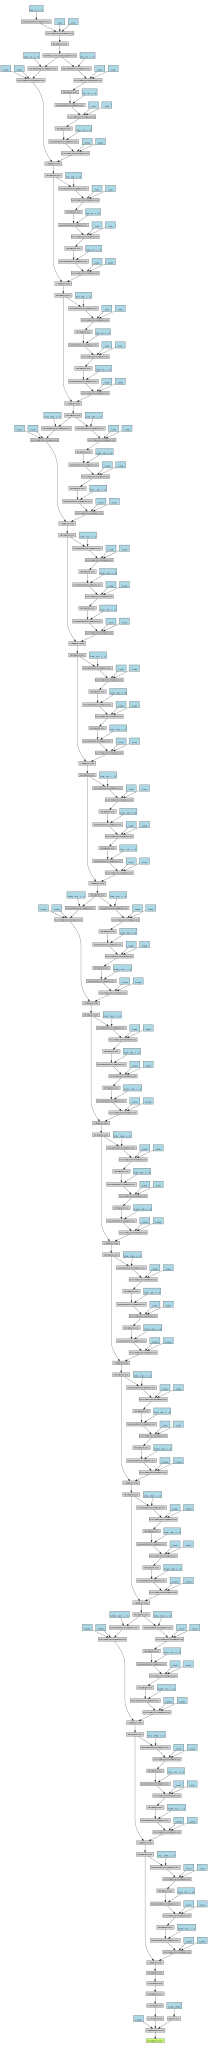

In [79]:
i = torch.rand(10, 3, 224, 224)
make_dot(resnet50(i).mean()) #, params=dict(resnet50.named_parameters()))

In [97]:
resnet50 = build_resnet('resnet50', 'classic')

Version: {'net': <class '__main__.ResNet'>, 'block': <class '__main__.Bottleneck'>, 'layers': [3, 4, 6, 3], 'num_classes': 1000}
Config: {'conv': <class 'torch.nn.modules.conv.Conv2d'>, 'conv_init': 'fan_out', 'nonlinearity': 'relu', 'last_bn_0_init': False, 'activation': <function <lambda> at 0x122955840>}


In [96]:
summary(resnet50, (3, 224, 224));

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14          [-1, 256,

In [95]:
build_resnet('resnet50', 'fanin');

Version: {'net': <class '__main__.ResNet'>, 'block': <class '__main__.Bottleneck'>, 'layers': [3, 4, 6, 3], 'num_classes': 1000}
Config: {'conv': <class 'torch.nn.modules.conv.Conv2d'>, 'conv_init': 'fan_in', 'nonlinearity': 'relu', 'last_bn_0_init': False, 'activation': <function <lambda> at 0x12298c7b8>}
